## Import Libraries

In [2]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

import warnings
warnings.filterwarnings( 'ignore')

In [3]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Load Dataset

We used the [BIST 100](https://finance.yahoo.com/quote/XU100.IS/history?p=XU100.IS) dataset.

In [4]:
df = pd.read_csv('XU100.IS.csv')

We will correct some errors in the database. We think that the reason for this error is the removal of zeros from the money.

In [5]:
# Drop rows with missing values (NaN)
df = df.dropna()

# Normalize the 'Close' column values up to index 5982 by dividing them by 100
df.loc[:5982, 'Open'] = df.loc[:5982, 'Open'] / 100
df.loc[:5982, 'High'] = df.loc[:5982, 'High'] / 100
df.loc[:5982, 'Low'] = df.loc[:5982, 'Low'] / 100
df.loc[:5982, 'Close'] = df.loc[:5982, 'Close'] / 100
df.loc[:5982, 'Adj Close'] = df.loc[:5982, 'Adj Close'] / 100

df = df.loc[df['Date'] < '2020-12-31']

In [6]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-07-01,18.570000,18.640000,18.260000,18.510000,18.510000,2.342600e+06
1,1997-07-02,18.510000,18.770000,18.490000,18.730000,18.730000,2.946200e+06
2,1997-07-03,18.730000,19.160000,18.710000,19.120000,19.120000,3.660300e+06
3,1997-07-04,19.120000,19.360000,18.970000,19.180000,19.180000,3.411100e+06
4,1997-07-07,19.180000,19.630000,19.180000,19.530000,19.530000,3.045500e+06
...,...,...,...,...,...,...,...
6087,2020-12-23,1409.199951,1420.800049,1409.199951,1417.699951,1417.699951,5.126165e+09
6088,2020-12-24,1420.199951,1432.300049,1415.400024,1426.000000,1426.000000,5.263356e+09
6090,2020-12-28,1431.699951,1442.800049,1431.699951,1439.300049,1439.300049,2.977132e+09
6091,2020-12-29,1443.000000,1459.699951,1436.199951,1459.699951,1459.699951,3.420867e+09


<Axes: >

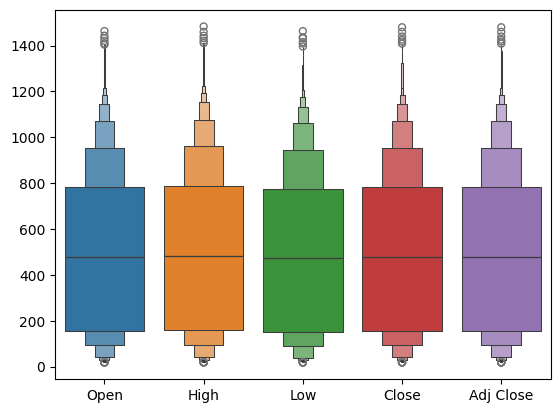

In [7]:
del df['Volume']
sns.boxenplot(df)

In [8]:
df = df[['Date', 'Close']]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5871 entries, 0 to 6092
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5871 non-null   object 
 1   Close   5871 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.6+ KB


In [10]:
df['Date'].min(), df['Date'].max()

('1997-07-01', '2020-12-30')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

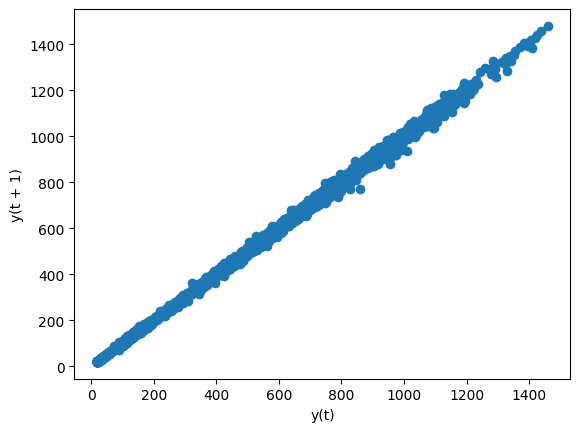

In [11]:
pd.plotting.lag_plot(df['Close'])

## Visualize the Data

In [12]:
fig = px.line(df.reset_index(), x='Date', y='Close', title='BIST 100 Inc. Stock Price 1997-2020')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Preprocess the Data

#### 1. Split the data

In [13]:
train_size = int(len(df) * 0.90)
test_size = len(df) - train_size
train, test = df.loc[0:train_size], df.loc[train_size:len(df)]
train.shape, test.shape

((5087, 2), (565, 2))

#### 2. Scale the data

In [14]:
scaler = StandardScaler()
scaler = scaler.fit(np.array(train['Close']).reshape(-1,1))
train = train.copy()
test = test.copy()
train.loc[:, 'Close'] = scaler.transform(np.array(train['Close']).reshape(-1,1))
test.loc[:, 'Close'] = scaler.transform(np.array(test['Close']).reshape(-1,1))

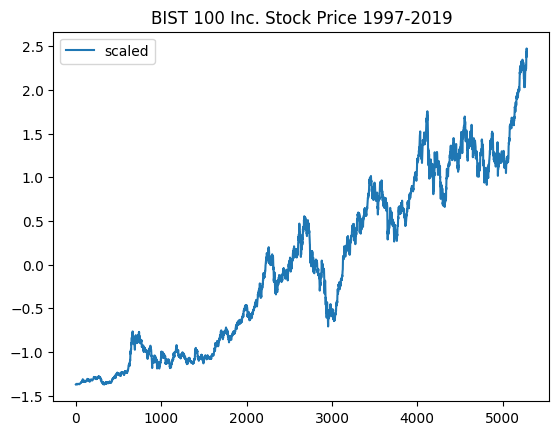

In [15]:
plt.plot(train['Close'], label = 'scaled')
plt.title('BIST 100 Inc. Stock Price 1997-2019')
plt.legend()
plt.show()

#### 3. Create sequences

In [16]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

In [17]:
X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (5057, 30, 1)
Testing input shape:  (535, 30, 1)


## Build a Model

In [18]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

## Train the Model

In [19]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/10
143/143 [==============================] - 18s 96ms/step - loss: 0.0651 - val_loss: 0.0505
Epoch 2/10
143/143 [==============================] - 13s 88ms/step - loss: 0.0228 - val_loss: 0.0714
Epoch 3/10
143/143 [==============================] - 13s 91ms/step - loss: 0.0142 - val_loss: 0.0701
Epoch 4/10
143/143 [==============================] - 13s 91ms/step - loss: 0.0138 - val_loss: 0.0982
Epoch 5/10
143/143 [==============================] - 13s 91ms/step - loss: 0.0128 - val_loss: 0.1122
Epoch 6/10
143/143 [==============================] - 13s 93ms/step - loss: 0.0169 - val_loss: 0.2030


#### Training and Validation Loss

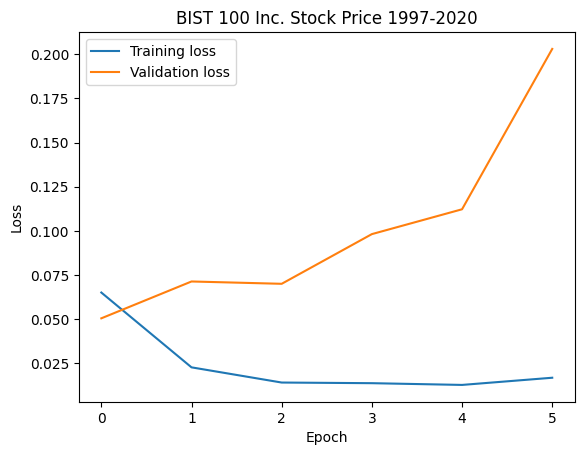

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("BIST 100 Inc. Stock Price 1997-2020")
plt.legend()
plt.show()

#### Mean Absolute Error Loss

159/159 [==============================] - 5s 28ms/step
Reconstruction error threshold: 0.8258427497480685


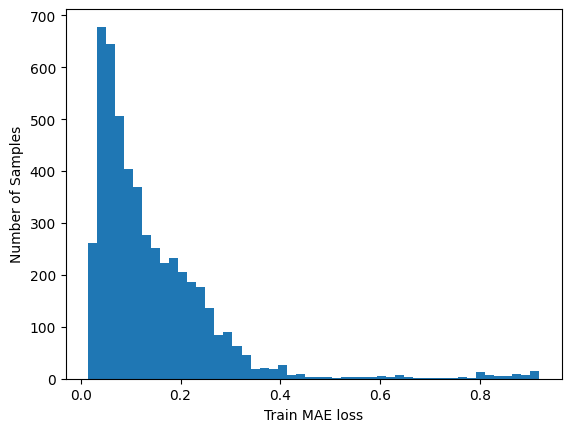

In [21]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss) * 0.9
print('Reconstruction error threshold:',threshold)

## Predict Anomalies

17/17 [==============================] - 0s 26ms/step


Text(0, 0.5, 'Number of samples')

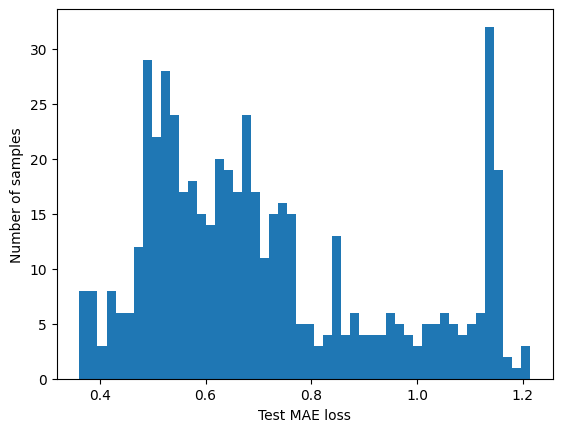

In [22]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [23]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [24]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
5313,2017-12-20,2.347630,0.846663,0.825843,True
5314,2017-12-21,2.375617,0.843253,0.825843,True
5315,2017-12-22,2.369710,0.841557,0.825843,True
5317,2017-12-26,2.400776,0.842657,0.825843,True
5318,2017-12-27,2.405673,0.843361,0.825843,True


In [25]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [26]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
5313,2017-12-20,2.347630,0.846663,0.825843,True
5314,2017-12-21,2.375617,0.843253,0.825843,True
5315,2017-12-22,2.369710,0.841557,0.825843,True
5317,2017-12-26,2.400776,0.842657,0.825843,True
5318,2017-12-27,2.405673,0.843361,0.825843,True


In [27]:
anomalies.shape

(148, 5)

In [28]:
if anomalies.shape[0]:
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1)).flatten(), name='Close price'))
  fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1)).flatten(), mode='markers', name='Anomaly'))
  fig.update_layout(showlegend=True, title='Detected anomalies')
  fig.show()

### Anomaly Detection with Library

In [29]:
!pip install adtk
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import PersistAD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00


In [30]:
data = pd.read_csv('XU100.IS.csv')

data = data.dropna()
data.loc[:5982, 'Open'] = data.loc[:5982, 'Open'] / 100
data.loc[:5982, 'High'] = data.loc[:5982, 'High'] / 100
data.loc[:5982, 'Low'] = data.loc[:5982, 'Low'] / 100
data.loc[:5982, 'Close'] = data.loc[:5982, 'Close'] / 100
data.loc[:5982, 'Adj Close'] = data.loc[:5982, 'Adj Close'] / 100
data = data.loc[data['Date'] < '2020-12-31']

open_data = data[['Date','Open']]
open_data = open_data.set_index('Date')
open_data.index = pd.to_datetime(open_data.index)
open_data

,Open
Date,
1997-07-01,18.570000
1997-07-02,18.510000
1997-07-03,18.730000
1997-07-04,19.120000
1997-07-07,19.180000
...,...
2020-12-23,1409.199951
2020-12-24,1420.199951
2020-12-28,1431.699951


Text(0.5, 1.0, 'Negative Persist Anomaly Detector')

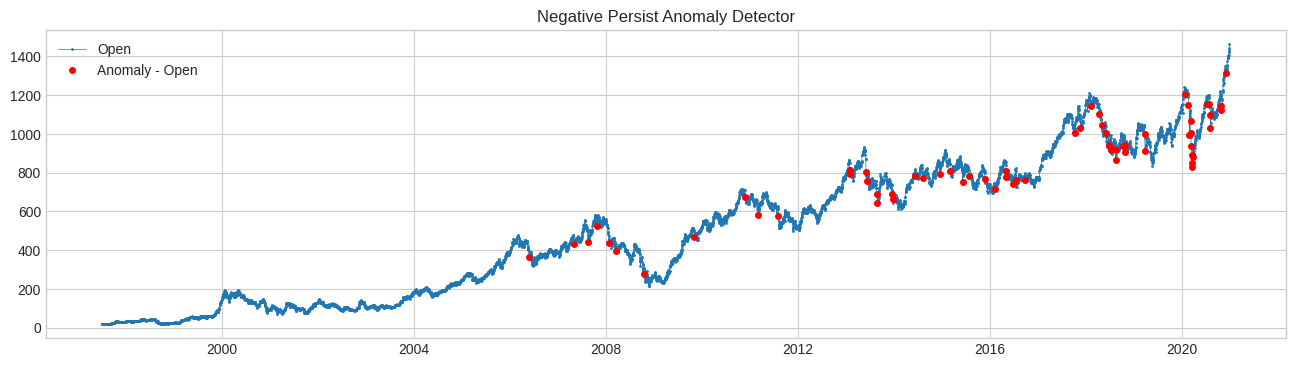

In [31]:
persist_detector = PersistAD(c=3, side='negative')
anomalies = persist_detector.fit_detect(open_data)
plot(open_data, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')
plt.title('Negative Persist Anomaly Detector')